# Wind Turbine Model
change the subscription_id with your Azure subscription id (see https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/SubscriptionsBlade)

In [1]:
subscription_id='24012c3a-e859-46e3-a32b-51894d277f46'

## Create the workspace or read from one created before

In [2]:
import azureml.core
print(azureml.core.VERSION)

from azureml.core import Workspace

# create
ws = Workspace.create(name='iiot-book-ml-workspace-2',
                      subscription_id=subscription_id,
                      resource_group='iiot-book-res',
                      create_resource_group=True,
                      location='westeurope' # or other supported Azure region
                     )
# load
#ws = Workspace.from_config()

/Users/giacomoveneri/Documents/workspace-iiot/exp/python-azure/env/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


0.1.68


### Get the WS details

In [3]:
# store information on the configuration file.
ws.write_config()


# see the details
ws.get_details()


Wrote the config file config.json to: /Users/giacomoveneri/Documents/workspace-iiot/exp/python-azure/aml_config/config.json


{'id': '/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourceGroups/iiot-book-res/providers/Microsoft.MachineLearningServices/workspaces/iiot-book-ml-workspace-2',
 'name': 'iiot-book-ml-workspace-2',
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'description': '',
 'friendlyName': 'iiot-book-ml-workspace-2',
 'containerRegistry': '/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourcegroups/iiot-book-res/providers/microsoft.containerregistry/registries/iiotbookacrwsqoawmu',
 'keyVault': '/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourcegroups/iiot-book-res/providers/microsoft.keyvault/vaults/iiotbookkeyvaultczbnvdzz',
 'applicationInsights': '/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourcegroups/iiot-book-res/providers/microsoft.insights/components/iiotbookinsightsjmxlghmt',
 'batchaiWorkspace': '/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourcegroups/iiot-book-res/providers/microsoft.batchai/worksp

## Experiment

In [4]:
from azureml.core import Experiment

# create a new experiment
exp = Experiment(workspace=ws, name='wind-turbine-experiment')

# start a run
run = exp.start_logging()

## Prepare the model

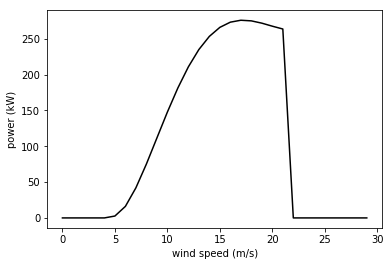

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def wind_turbine_model(x):

    # cut-in pseed vs cut-out speed
    if x<4.5 or x>21.5:
        return 0.0

    # standard operability
    return 376.936 - 195.8161*x + 33.75734*x**2 - 2.212492*x**3 + 0.06309095*x**4 - 0.0006533647*x**5


reference_power = [wind_turbine_model(x) for x in range(0,30)]

# show data and reference
fig, ax = plt.subplots()
#ax.plot(df.wind_speed_ms, df.power_generated_kw,'.r')
ax.plot(reference_power,'k')
ax.set_xlabel('wind speed (m/s)')
ax.set_ylabel('power (kW)')
plt.show()




In [13]:
run.log_list('Turbine Model', reference_power) # log a list of values

In [14]:
# log a image 
#run.log_image('Turbine Model', plt) 

# finish the run
run.complete()

print(run.get_portal_url())

https://mlworkspace.azure.ai/portal/subscriptions/24012c3a-e859-46e3-a32b-51894d277f46/resourceGroups/iiot-book-res/providers/Microsoft.MachineLearningServices/workspaces/iiot-book-ml-workspace-2/experiments/wind-turbine-experiment/runs/13ec4cf0-1551-445c-b427-fbabefce08c1


## Deploy the model

### Create Test ENV

In [15]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
#myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [16]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults



### register the model

In [17]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "NONE",  "method" : "phisics-based"}, 
                                               description='Wind turbine power')

### Deploy

In [18]:
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="core.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='wind-turbine',
                                       deployment_config=aciconfig,
                                       models=[],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

print(service.scoring_uri)

Creating image
Image creation operation finished for image wind-turbine:2, operation "Succeeded"
Creating service
Running....................................
SucceededACI service creation operation finished, operation "Succeeded"
http://137.117.213.215:80/score


## Test the WS

In [19]:
import requests
import json

# send a random row from the test set to score
input_data = "{\"data\": 15}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)

print("result:", resp.text)

POST to url http://137.117.213.215:80/score
result: "265.7660246874989"


## Clean all

In [21]:
service.delete()
ws.delete(delete_dependent_resources=True)

WebserviceException: Received bad response from Model Management Service:
Response Code: 404
Headers: {'Date': 'Fri, 19 Oct 2018 12:51:11 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'api-supported-versions': '2018-03-01-preview', 'x-ms-client-request-id': '20ad6ca251864ff9a4182faaaed1c6fa', 'x-ms-client-session-id': '', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload', 'Content-Encoding': 'gzip'}
Content: b'{"code":"NotFound","statusCode":404,"message":"The specified resource was not found","details":[{"code":"NotFoundWorkspace","message":"Workspace does not exist."}]}'